# Analysis of Lipid Bilayer Dataset

Phospholipid bilayers represent a useful model description for cell membranes. 
The phospholipid defines the interface between the inside and outside of the cell, and reflectometry techniques lend themselves well to the study of these systems. 
However, in order to get the most from our reflectometry data, we must produce an accurate and descriptive model for the experimental system. 
To build this model, we will use the Python library [`refnx`](https://refnx.readthedocs.io/en/latest/index.html) and this Jupyter Notebook. 

<img src='./assets/bilayer.png' width='30%'><br>
<small>
A pictorial description of a phospholipid bilayer.
</small>

## Intended Learning Outcomes

- Use the `refnx.reflect.LipidBilayer` in the analysis of multiple contrast neutron reflectometry data from a lipid bilayer at the solid-liquid interface. 
- Contextualise the implementation of the `refnx.reflect.LipidBilayer` class in the multilayer interpretation of reflectometry analysis
- Assess how neutron reflectometry could be used in the analysis of your systems of interest. 

This example has been taken from the [`refnx` documentation](https://refnx.readthedocs.io/en/latest/lipid.html) that was developed by [Andrew Nelson](https://www.ansto.gov.au/people/dr-andrew-nelson) (ANSTO).

## Description of the data

The data that you will be looking at was collected at the Platypus reflectometer at the ANSTO reactor source in Australia. 
The data are stored as four columns ASCII files, with the columns representing the *q*-vectors, the measured reflectivity, the uncertainty in the measured reeflectivity, and the width of a Gaussian resolution function. 
Files are present from three measurements, the system that was measured consists of a slab of silicon, the bilayer of DMPC (1,2-dimyristoyl-*sn*-glycero-3-phosphocholine) and water, arranged as shown below. 
The neutrons enter the sample through the silicon. 

```
|--Silicon--|
|-----------|
|--Bilayer--|
|-----------|
|---Water---|
```

The three measurements were obtained by changing the hydrogen/deuterium ratio in the water. 
It is assumed that this has no effect on the structure of the bilayer and therefore offered multiple measurements of the same structural system that can be corefined. 

Let's start with reading in the data and plotting it. 
To do this, we will use the `ReflectDataset` class from `refnx`. 

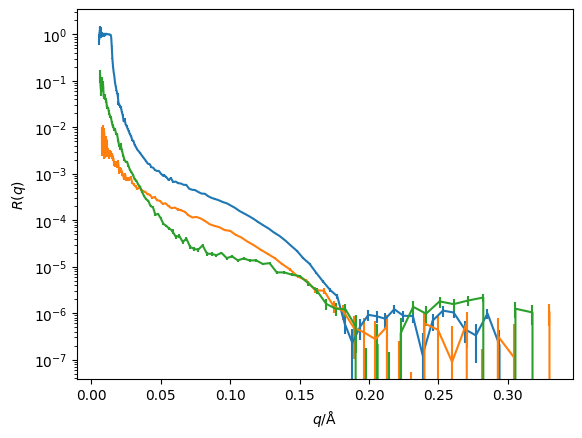

In [40]:
import matplotlib.pyplot as plt
from refnx.dataset import ReflectDataset

data_d2o = ReflectDataset('./data//bilayer_d2o.dat')
data_hdmix = ReflectDataset('./data/bilayer_hdmix.dat')
data_h2o = ReflectDataset('./data/bilayer_h2o.dat')

fig, ax = plt.subplots()
data_d2o.plot(fig)
data_hdmix.plot(fig)
data_h2o.plot(fig)
ax.set_xlabel('$q$/Å')
ax.set_ylabel('$R(q)$')
ax.set_yscale('log')
plt.show()

The three datasets are noticably different, despite coming from the same structural system. 
This is the effect of changing from pure D<sub>2</sub>O to a mixture of D<sub>2</sub>O and H<sub>2</sub>O to pure H<sub>2</sub>O.

## Building the Model

Having seen the data, the next aim is to build the structural model for the system. 
As is shown above in the description of the sample, the bilayer is assembled on a silicon block. 
Therefore, it is necessary that we have an object of type `SLD` that can be used to describe the silicon. 

In [41]:
from refnx.reflect import SLD

si = SLD(2.07, name='Si')
si

SLD([Parameter(value=2.07, name='Si - sld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='Si - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None)], name='Si')

Notice that this function takes a single argument, the scattering length density of the material in units of 10 <sup>-6</sup> Å<sup>-2</sup>. 
Scattering length densities can have imaginary components, but for the materials investigated here they are all 0. 

#### Task: Create the remaining materials

The silicon block has a naturally formed layer of SiO<sub>2</sub> on it. Therefore we need a `SLD` object for SiO<sub>2</sub> as well as the three isotopically different forms of water used. 
Create the four other `SLD` objects in the empty notebook cell below, use the variable names given in the table. 

| Material    | SLD (10 <sup>-6</sup> Å<sup>-2</sup>) |
| -------- | ------- |
| `sio2`  | 3.47    |
| `d2o` | 6.36    |
| `hdmix`    | 2.07  |
| `h2o` | -0.56 | 

In [42]:
### ANSWER

sio2 = SLD(3.4, name='SiO2')
d2o = SLD(6.36, name='D2O')
hdmix = SLD(2.07, name='HD-Mix')
h2o = SLD(-0.56, name='H2O')

These objects are all potentially parameters that can be refined in the model fitting process. 
We can see if a parameter is able to vary with the following command (notice that since the `SLD` object may include an imaginary component it in fact contains two parameters). 

In [43]:
d2o.real.vary

False

Currently, the real SLD of the `d2o` object is not able to vary. 
This can be changed with the `setp` method. 

In [44]:
d2o.real.setp(vary=True, bounds=(6.1, 6.36))
d2o.real.vary

True

This will ensure that in the optimisation, the value of `d2o` is constrained between the values of 6.1 &times;10 <sup>-6</sup> Å<sup>-2</sup> and 6.36 &times;10 <sup>-6</sup> Å<sup>-2</sup>. 

The next step will be to create a layer of the SiO<sub>2</sub> material. 
To do this we call the `sio2` object with two values, the first is the thickness of the layer and the second is the roughness between this layer and the layer above it (for the SiO<sub>2</sub> layer this is the pure silicon layer) in ångströms.

In [45]:
sio2_layer = sio2(15, 3)
sio2_layer.name = 'SiO2 Layer'
print(sio2_layer)

________________________________________________________________________________
Parameters:  'SiO2 Layer'  
<Parameter:'SiO2 - thick' , value=15  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter: 'SiO2 - sld'  , value=3.4  (fixed) , bounds=[-inf, inf]>
<Parameter: 'SiO2 - isld' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'SiO2 - rough' , value=3  (fixed) , bounds=[-inf, inf]>
<Parameter:'SiO2 - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>


#### Task: Varying Parameters of the SiO<sub>2</sub> Layer

You should notice that the `sio2_layer` object has a few parameters associated with it; thickness, roughness, and solvent volume fraction. 
Similar to the SLD, these can be allowed to vary. 
Set the `sio2_layer` parameters in the table to vary between the given bounds in the cell below.

| Parameter | Min | Max |
| -------- | ------- | ------- |
| `thick` | 2 | 30 |
| `rough` | 0 | 7 |
| `vfsolv` | 0.0 | 0.5 | 

In [46]:
### ANSWER

sio2_layer.thick.setp(vary=True, bounds=(2, 30))
sio2_layer.rough.setp(vary=True, bounds=(0, 7))
sio2_layer.vfsolv.setp(vary=True, bounds=(0, 0.5))

The next step is to create the `refnx.reflect.LipidLeaflet` objects (note that two will be required, one for each layer in the bilayer). 
This imposes some physical constraints on our model, specifically that the number of head groups in the lipid layers must be equal to the number of pairs of tail groups. 
This constraint makes logical sense, as there is covalent chemical bonds between these components of the phospholipid. 
Let's look at the input requirements for the `refnx.reflect.LipidLeaflet`. 

In [47]:
from refnx.reflect import LipidLeaflet

LipidLeaflet?

Init signature:
LipidLeaflet(
    apm,
    b_heads,
    vm_heads,
    thickness_heads,
    b_tails,
    vm_tails,
    thickness_tails,
    rough_head_tail,
    rough_preceding_mono,
    head_solvent=None,
    tail_solvent=None,
    reverse_monolayer=False,
    name='',
)
Docstring:     
Describes a lipid leaflet Component at an interface

Parameters
----------
APM: float or refnx.analysis.Parameter
b_heads: float, refnx.analysis.Parameter, complex or SLD
    Sum of coherent scattering lengths of head group (Angstrom).
    When an SLD is provided it is simply an easy way to provide a complex
    value. `LipidLeaflet.b_heads_real` is set to `SLD.real`, etc.
vm_heads: float or refnx.analysis.Parameter
    Molecular volume of head group (Angstrom**2)
thickness_heads: float or refnx.analysis.Parameter
    Thickness of head group region (Angstrom)
b_tails: float, refnx.analysis.Parameter, complex or SLD
    Sum of coherent scattering lengths of tail group (Angstrom).
    When an SLD is provi

It can be seen that there are a large number of inputs required, so let's build these one by one. 
The first is the `apm` or area per molecule, this is the area that each lipid occupies in the lipid layer. 
We will create this directly as a `Parameter`. 

In [48]:
from refnx.analysis import Parameter

apm = Parameter(56, name='area per molecule', vary=True, bounds=(52, 65))
apm

Parameter(value=56.0, name='area per molecule', vary=True, bounds=Interval(lb=52.0, ub=65.0), constraint=None)

#### Task: Remaining Parameter Creation 

Using the `Parameter` function, you should create the remaining parameters (given in the table below) for the `LipidLeafet` in the cell below. 
Where no min and max value is given, the parameter should not be able to vary. 
We will then discuss what each of these parameters means.

| Parameter | Initial Value | Min | Max |
| -------- | ------- | ------- | ------- |
| `b_heads` | 6.01&times;10<sup>-4</sup> | -- | -- |
| `b_tails` | -2.92&times;10<sup>-4</sup> | -- | -- |
| `v_heads` | 319 | -- | -- |
| `v_tails` | 782 | -- | -- |
| `inner_head_thickness` | 9 | 4 | 11 |
| `outer_head_thickness` | 9 | 4 | 11 |
| `tail_thickness` | 14 | 10 | 17 |
| `solv_roughness` | 3 | 0 | 5 |

In [49]:
### ANSWER
b_heads = Parameter(6.01e-4, 'b_heads')
b_tails = Parameter(-2.92e-4, 'b_tails')

v_heads = Parameter(319, 'v_heads')
v_tails = Parameter(782, 'v_tails')

inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))
solv_roughness = Parameter(3, 'solv_roughness', vary=True, bounds=(0, 5))

These parameters are the following:
- `b_heads` and `b_tails` are the scattering lengths of the heads and tails (in ångströms), respectively.
- `v_heads` and `v_tails` are the volume occupied by the heads and tails (in ångströms<sup>3</sup>), respectively.
- `inner_head_thickness` is the thickness of the head layer that is next to the silicon block.
- `outer_head_thickness` is the same parameter for the head layer at the water.
- `tail_thickness` is the tail layer thickness. 

The two `LipidLeaflet` can now be created, with roughness values of 3 Å.

In [50]:
inner_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 3)

outer_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, outer_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 0, reverse_monolayer=True)

Note that for the `outer_leaflet` the monolayer is reversed so that the tails are in contact between the two layers. 

The final step to build the model is to bring all of the layers together for each of the three isotopic contrasts. 

In [51]:
s_d2o = si | sio2_layer | inner_leaflet | outer_leaflet | d2o(0, solv_roughness)
s_hdmix = si | sio2_layer | inner_leaflet | outer_leaflet | hdmix(0, solv_roughness)
s_h2o = si | sio2_layer | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)

The `si` layer has no roughness as it is the top layer in the model. 

## Calculating Reflectometry from the Models

With the model created, we now need to add some reflectometry parameters, the scaling of the data and the background level (only the `s_d2o` system requires a change of scale). 
This is done with the `refnx.reflect.ReflectModel` objects. 

In [52]:
from refnx.reflect import ReflectModel

model_d2o = ReflectModel(s_d2o)
model_hdmix = ReflectModel(s_hdmix)
model_h2o = ReflectModel(s_h2o)

model_d2o.scale.setp(vary=True, bounds=(0.9, 1.1))

model_d2o.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))
model_hdmix.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))
model_h2o.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))

Finally, similar to the previous example, a `Objective` is created. 
However, this time one is created for each of the systems and these are merged into a `GlobalObjective`.

In [53]:
from refnx.analysis import Objective, GlobalObjective

objective_d2o = Objective(model_d2o, data_d2o)
objective_hdmix = Objective(model_hdmix, data_hdmix)
objective_h2o = Objective(model_h2o, data_h2o)

global_objective = GlobalObjective([objective_d2o, objective_hdmix, objective_h2o])

Before we perform the fitting, we can look at the current agreement between the model and the data. 

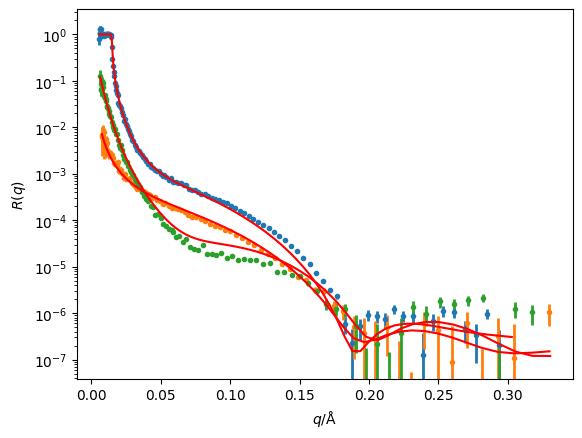

In [54]:
fig, ax = plt.subplots()
global_objective.plot(fig=fig)
ax.set_xlabel('$q$/Å')
ax.set_ylabel('$R(q)$')
ax.set_yscale('log')
plt.show()

The `GlobalObjective` acts in the same way as the `Objective` objects. 
Therefore, they can be passed to the `CurveFitter` and a fitting algorithm may be applied. 

In [55]:
from refnx.analysis import CurveFitter

fitter = CurveFitter(global_objective)
fitter.fit('differential_evolution')

-2735.0307463994795: : 71it [00:12,  5.82it/s]/Users/ee23687/miniforge3/envs/refnx/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
-2735.0307463994795: : 71it [00:12,  5.63it/s]


 message: Optimization terminated successfully.
 success: True
     fun: -2735.0307463994795
       x: [ 1.039e+00 -2.655e-07 ...  2.555e-07  4.811e-08]
     nit: 71
    nfev: 14082
   covar: [[ 1.347e-05  4.380e-11 ...  1.401e-11  1.521e-11]
           [ 4.380e-11  1.661e-14 ... -3.622e-15  3.981e-15]
           ...
           [ 1.401e-11 -3.622e-15 ...  1.010e-14  1.876e-16]
           [ 1.521e-11  3.981e-15 ...  1.876e-16  1.269e-14]]
  stderr: [ 3.670e-03  1.289e-07 ...  1.005e-07  1.127e-07]

With the fitting complete, we check that the fit has improved. 

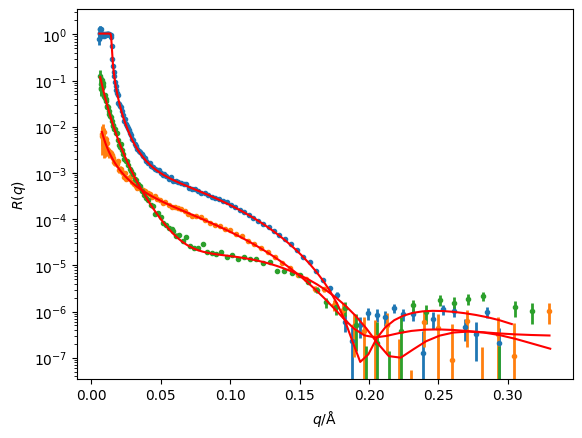

In [56]:
fig, ax = plt.subplots()
global_objective.plot(fig=fig)
ax.set_xlabel('$q$/Å')
ax.set_ylabel('$R(q)$')
ax.set_yscale('log')
plt.show()

We can also have a look at the optimised values of the varying parameters. 

In [57]:
print(global_objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.03864 +/- 0.00367, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=-2.65511e-07 +/- 1.29e-07, bounds=[-1e-06, 1e-06]>
<Parameter:'SiO2 - thick' , value=13.3551 +/- 0.225, bounds=[2.0, 30.0]>
<Parameter:'SiO2 - rough' , value=5.88929 +/- 0.548, bounds=[0.0, 7.0]>
<Parameter:'SiO2 - volfrac solvent', value=0.142491 +/- 0.00703, bounds=[0.0, 0.5]>
<Parameter:'area per molecule', value=57.838 +/- 0.223, bounds=[52.0, 65.0]>
<Parameter:'inner_head_thickness', value=9.35026 +/- 0.15 , bounds=[4.0, 11.0]>
<Parameter:'tail_thickness', value=13.5249 +/- 0.139, bounds=[10.0, 17.0]>
<Parameter:'outer_head_thickness', value=5.58691 +/- 1.79 , bounds=[4.0, 11.0]>
<Parameter:  'D2O - sld'  , value=6.17483 +/- 0.00477, bounds=[6.1, 6.36]>
<Parameter:'solv_roughness', value=1.01905 +/- 4.81 , bounds=[0.0, 5.0]>
<Parameter:     'bkg'     , value=2.55522e-

We can look at the resulting scattering length density profiles. 

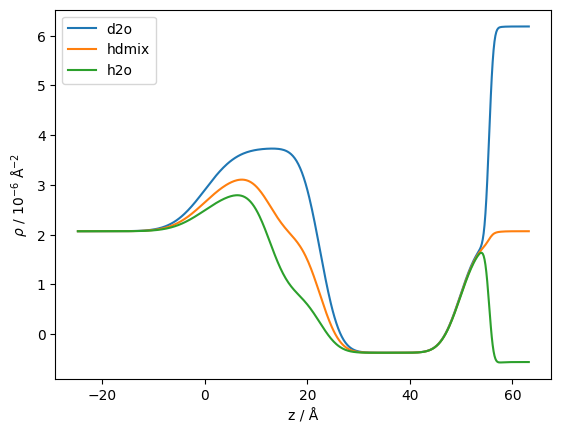

In [60]:
fig, ax = plt.subplots()
ax.plot(*s_d2o.sld_profile(), label='d2o')
ax.plot(*s_hdmix.sld_profile(), label='hdmix')
ax.plot(*s_h2o.sld_profile(), label='h2o')
ax.set_ylabel("$\\rho$ / $10^{-6}$ Å$^{-2}$")
ax.set_xlabel("z / Å")
ax.legend()
plt.show()

#### Task: Perform MCMC on the Bilayer System

In the previous exercise, you performed Markov chain Monte Carlo (MCMC) sampling to investigate the posterior distribution for the system. 
Perform the same operation and plot the corner plot for the posterior distribution. 
*Note, this may be very slow on the Binder resource and is probably best to run locally*.

  0%|          | 0/400 [00:00<?, ?it/s]/Users/ee23687/miniforge3/envs/refnx/lib/python3.10/site-packages/refnx/_lib/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [04:01<00:00, 12.44it/s]


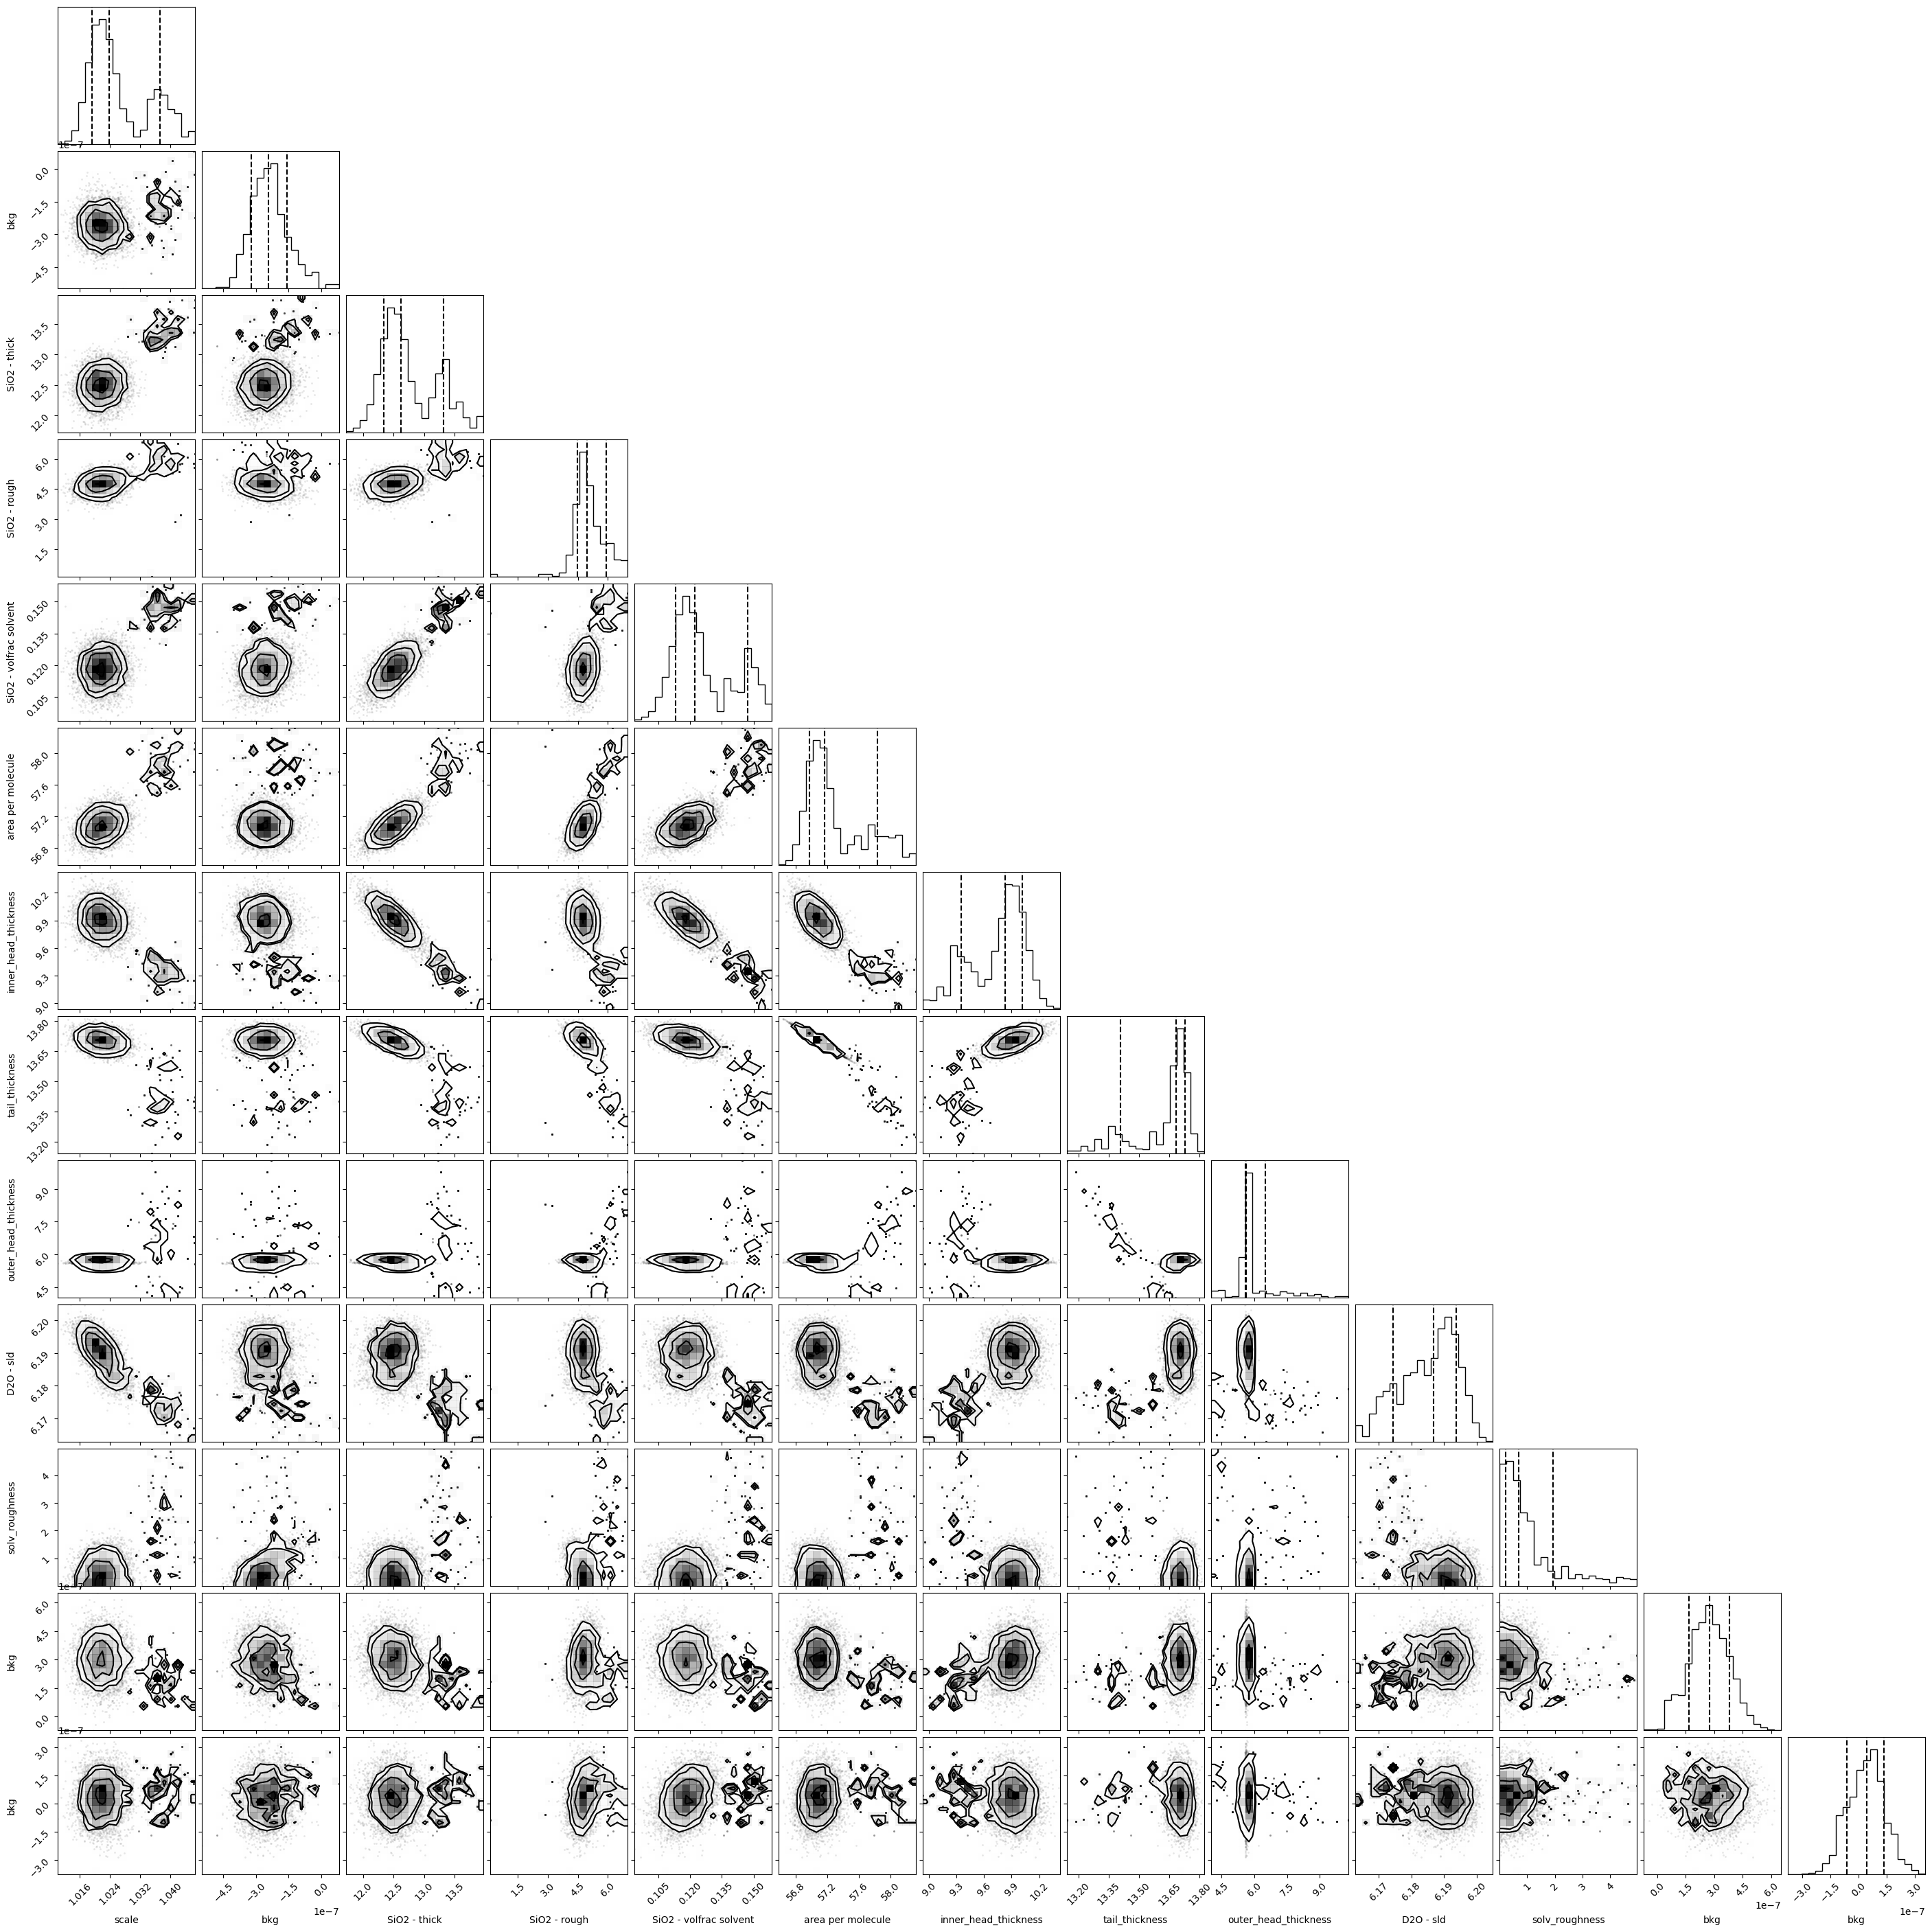

In [58]:
### ANSWER

fitter.sample(400)
fitter.sampler.reset()
fitter.sample(30, nthin=100)

global_objective.corner()
plt.show()